# Advanced PM: Full Pipeline

This notebook combines all the components from previous tutorials into a production-quality simulation pipeline:
- PM N-body integration with **PGD correction** for small-scale sharpening
- **OnionTiler** for artifact-free full-sky spherical maps
- Multi-shell lightcone with angular power spectrum validation

This is the configuration you would use for a real analysis before applying lensing (covered in notebook 07).

## Setup

In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

import fwd_model_tools as ffi

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
ERROR:2026-02-12 16:50:55,315:jax._src.xla_bridge:491: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 489, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/j

## Simulation Configuration

In [2]:
key = jax.random.PRNGKey(0)
mesh_size = (256, 256, 256)
box_size = (2000.0, 2000.0, 2000.0)
nside = 256
nb_shells = 8
cosmo = ffi.Planck18()

## Initial Conditions and LPT Initialization

In [3]:
initial_field = ffi.gaussian_initial_conditions(
    key, mesh_size, box_size,
    cosmo=cosmo,
    nside=nside,
)

t0 = 0.1
dx, p = ffi.lpt(cosmo, initial_field, scale_factor_spec=t0, order=1)
print(f"LPT initialized at a={t0}, mesh={mesh_size}, box={box_size[0]} Mpc/h")

LPT initialized at a=0.1, mesh=(256, 256, 256), box=2000.0 Mpc/h


## Build the Advanced Solver

The solver combines:
- `PGDKernel`: corrects particle positions at each step to recover small-scale power lost by the PM force resolution
- `OnionTiler`: replicates and rotates the box for smooth full-sky coverage

In [15]:
alpha = 0.2  # Adjust these values
kl = 0.3
ks = 1.0

solver = ffi.ReversibleDoubleKickDrift(
    #pgd_kernel=ffi.PGDKernel(alpha=alpha, kl=kl, ks=ks),
    interp_kernel=ffi.OnionTiler(painting=ffi.PaintingOptions(target="spherical", scheme="bilinear" , drift_on_lightcone=False)),
)

## Run N-body

In [16]:
max_a_with_onion_tiler = jc.background.a_of_chi(cosmo , initial_field.max_comoving_radius * 2).squeeze()
ts = jnp.linspace(max_a_with_onion_tiler, 1.0, nb_shells)

In [17]:
lightcone = ffi.nbody(
    cosmo, dx, p,
    t1=1.0, dt0=0.05,
    ts=ts,
    solver=solver,
)

print(f"Lightcone type: {type(lightcone).__name__}")
print(f"Lightcone shape: {lightcone.shape}")
print(f"Scale factors: {lightcone.scale_factors}")

Lightcone type: SphericalDensity
Lightcone shape: (8, 786432)
Scale factors: [1.         0.93517302 0.87034604 0.80551906 0.74069208 0.6758651
 0.61103812 0.54621114]


## Visualize Multi-Shell Lightcone

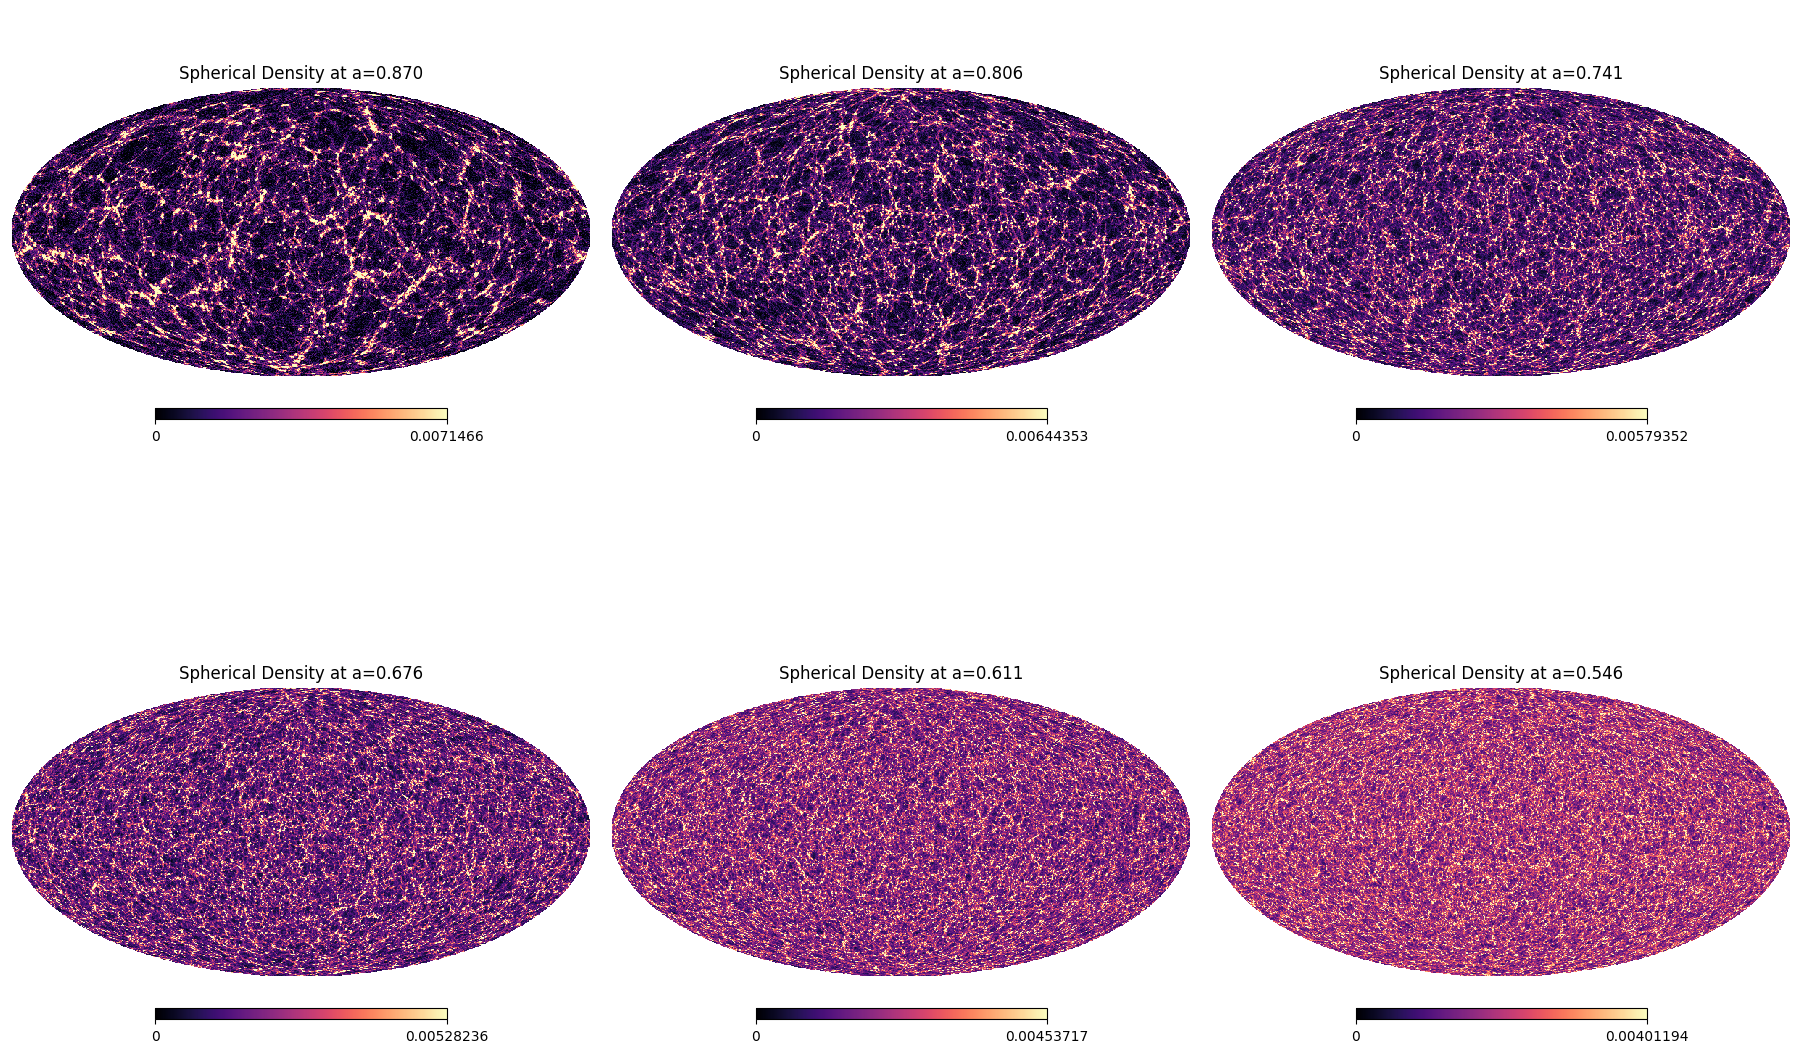

In [7]:
lightcone[-6:].show()

## Power Spectra vs Theory

Compare the measured angular power spectrum of each shell against the linear theory prediction.

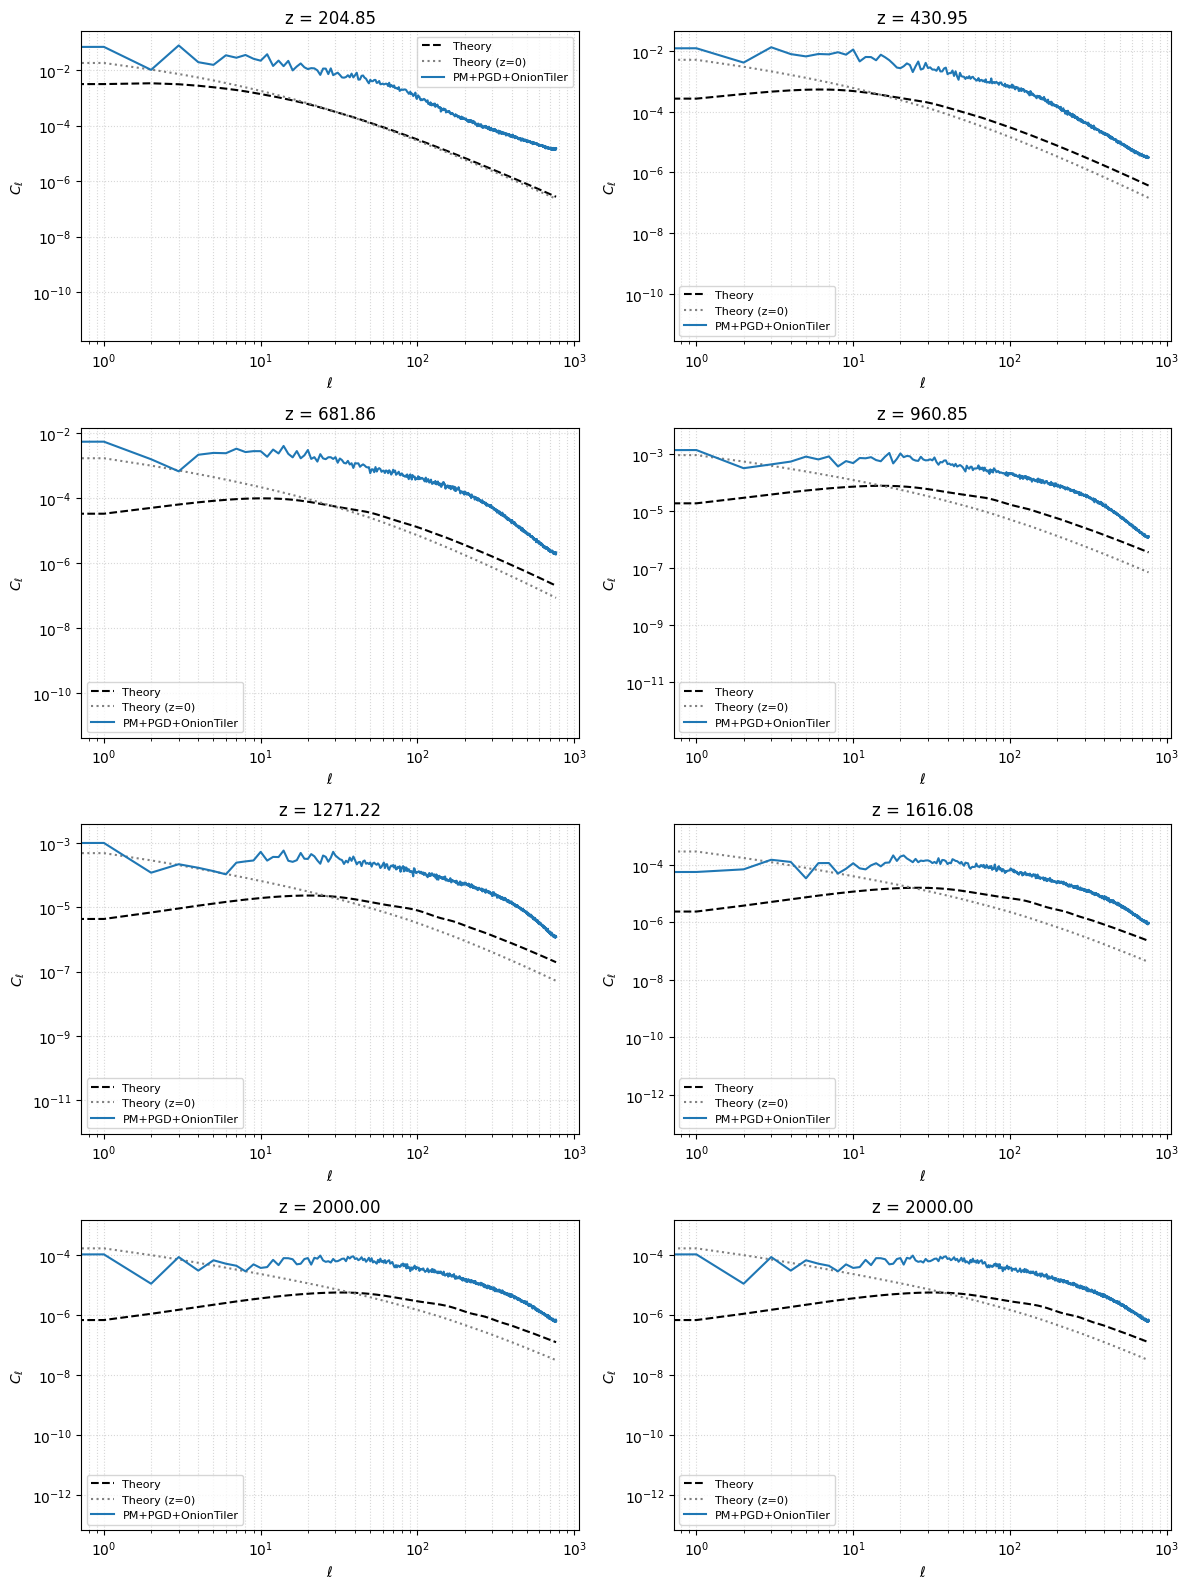

In [25]:
r_center = lightcone.comoving_centers[1:]
r_edges_arr = ffi.edges(r_center)
r_nf = jnp.stack([r_edges_arr[1:], r_edges_arr[:-1]], axis=-1)
a_nf = jc.background.a_of_chi(cosmo, r_nf)
z_src = jc.utils.a2z(a_nf)
z_near, z_far = z_src[..., 1], z_src[..., 0]
nz_s = [ffi.tophat_z(n, f, gals_per_arcmin2=1.0) for n, f in zip(z_near, z_far)]
nz_s_2 = [ffi.tophat_z(0.0, f, gals_per_arcmin2=1.0) for n, f in zip(z_near, z_far)]

LMAX = 3 * nside - 1
ells = jnp.arange(LMAX)
theory_cl = ffi.compute_theory_cl(
    cosmo, ell=ells, z_source=nz_s,
    probe_type="number_counts", nonlinear_fn="linear", cross=False,
)
theory_cl_2 = ffi.compute_theory_cl(cosmo, ell=ells, z_source=nz_s_2, probe_type="number_counts", nonlinear_fn="linear", cross=False)

# Compute measured C_ell
overdensity_lc = (lightcone / lightcone.mean(axis=1, keepdims=True)) - 1.0
cl_measured = overdensity_lc[1:].angular_cl(method="healpy")

# Plot
ncols = 2
nrows = (nb_shells + 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

for i in range(nb_shells):
    theory_cl[i].plot(ax=axes[i], logx=True, logy=True, label="Theory", color="black", linestyle="--")
    theory_cl_2[i].plot(ax=axes[i], logx=True, logy=True, label="Theory (z=0)", color="gray", linestyle=":")
    cl_measured[i].plot(ax=axes[i], logx=True, logy=True, label=f"PM+PGD+OnionTiler")
    axes[i].set_title(f"z = {float(r_center[i]):.2f}")
    axes[i].legend(fontsize=8)

for i in range(nb_shells, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()